# Tarea de Programación - Superando el Overfitting: Construyendo una CNN Robusta

¡Bienvenido a la tarea final de este curso! Has construido una base sólida en PyTorch, pasando de tensores básicos a una Red Neuronal Convolucional completa y funcional en un laboratorio anterior. Ese fue un primer paso esencial. Ahora, es momento de dar el siguiente paso y enfrentar un desafío que todo practicante de deep learning encuentra: tomar un modelo prometedor pero imperfecto y elevarlo.

Tu modelo anterior mostró signos claros de overfitting, un obstáculo común donde una red memoriza los datos de entrenamiento en lugar de aprender a generalizar. Esta tarea es tu misión para resolver ese problema, no solo ajustando un parámetro, sino re-ingenierizando sistemáticamente todo tu pipeline de machine learning con un conjunto de herramientas y técnicas profesionales.

Para lograr esto, desplegarás una estrategia multifacética, mejorando cada componente de tu configuración:

* **Mejorar el Data Pipeline** con un aumento de datos (data augmentation) más potente para crear un conjunto de entrenamiento más rico.

* **Refactorizar la Arquitectura para la Modularidad**, creando `CNNBlocks` reutilizables para un código más limpio y escalable.

* **Integrar Capas Avanzadas** como **Batch Normalization** para estabilizar el entrenamiento y mejorar la generalización.

* **Desplegar una Estrategia de Regularización Robusta** utilizando **Dropout** y **Weight Decay** para combatir el overfitting directamente.

¡Comencemos y elevemos tu modelo al siguiente nivel!

---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

* To submit your notebook for grading, first save it by clicking the 💾 icon on the top left of the page and then click on the `Submit assignment` button on the top right of the page.
---

## Table of Contents
- [Imports](#0)
- [1 - Upgrading Your Data Pipeline](#1)
    - [1.1 - Defining More Powerful Transformations](#1-1)
        - **[Exercise 1 - define_transformations](#ex-1)**
    - [1.2 - Assembling the Data Loaders](#1-2)
    - [1.3 - Visualizing the Training Images](#1-3)
- [2 - Building a Modular and Robust CNN](#2)
    - [2.1 - The Power of Modularity: The CNNBlock](#2-1)
        - [2.1.1 - BatchNorm2d Layer](#2-1-1)
            - **[Exercise 2 - CNNBlock](#ex-2)**
    - [2.2 - Assembling the Full CNN with Modular Blocks](#2-2)
        - **[Exercise 3 - SimpleCNN](#ex-3)**
- [3 - Training the Upgraded Model](#3)
    - [3.1 - Configuring the Loss and Optimizer](#3-1)
    - [3.2 - Implementing the Training and Validation Logic](#3-2)    
        - **[Exercise 4 - train_epoch](#ex-4)**
        - **[Exercise 5 - validate_epoch](#ex-5)**        
- [4 - Beyond the Foundations: A Glimpse into the Next Level](#4)

<a name='0'></a>

## Imports

In [1]:
import copy 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
import helper_utils
#import unittests

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


<a name='1'></a>
## 1 - Mejorando tu Data Pipeline

En el primer laboratorio de este módulo, construiste un potente clasificador CNN desde cero. Aunque funcionó, también te encontraste con un obstáculo clásico del machine learning: el **overfitting**. Tu modelo comenzó a memorizar los datos de entrenamiento en lugar de aprender a generalizar, un problema común cuando el rendimiento de un modelo en los datos de validación se estanca o degrada.

Tus resultados de entrenamiento de ese laboratorio probablemente produjeron un gráfico similar al de abajo. Ilustra perfectamente este desafío, mostrando los signos reveladores del overfitting. Observa de cerca la brecha cada vez mayor entre la **training loss**, que continúa mejorando, y la **validation loss**, que se estanca o incluso empeora. Esta divergencia, junto con la **validation accuracy** alcanzando una meseta, es la evidencia clásica de un modelo que está memorizando los datos de entrenamiento en lugar de aprender realmente a generalizar.

![Lab 1 Training Plot](nb_image/lab_1_training_plot.png)



Ahora enfrentarás este desafío directamente. El objetivo es doble: primero, resolver el overfitting, y segundo, llevar el rendimiento de tu modelo a nuevas alturas. Sin embargo, antes de poder mejorar la arquitectura del modelo, primero debes mejorar los datos de los que aprende.

Una estrategia fundamental para construir modelos más robustos es el **data augmentation**. Al crear versiones modificadas de tus imágenes de entrenamiento, volteándolas o rotándolas, le enseñas a tu modelo a reconocer sujetos en una variedad de condiciones. Esta técnica es una primera línea de defensa crucial contra el overfitting. Tu primera tarea es construir un conjunto de transformaciones de imagen aún más potente para potenciar tu dataset.

<a name='1-1'></a>
### 1.1 - Definiendo Transformaciones más Potentes

Comencemos configurando los componentes esenciales para tu data pipeline. Empezarás definiendo los valores de normalización estándar para el dataset CIFAR-100 y luego crearás los pipelines de transformación propiamente dichos.

* Define `cifar100_mean` y `cifar100_std`, los valores de media y desviación estándar para el dataset **CIFAR-100**.

In [5]:
# Pre-calculated mean for each of the 3 channels of the CIFAR-100 dataset
cifar100_mean = (0.5071, 0.4867, 0.4408)
# Pre-calculated standard deviation for each of the 3 channels of the CIFAR-100 dataset
cifar100_std = (0.2675, 0.2565, 0.2761)

Como aprendiste anteriormente, el pipeline de transformaciones de entrenamiento es donde aplicas el data augmentation. Para hacer tu modelo aún más robusto, esta vez añadirás una nueva técnica a tu arsenal: `RandomVerticalFlip`. Aunque el volteo horizontal es común, añadir volteos verticales también puede ayudar al modelo a aprender que la orientación de un objeto no siempre es vertical, una característica útil para clasificar cosas como insectos o flores desde varios ángulos.



<a name='ex-1'></a>
### Exercise 1 - define_transformations

Tu tarea es definir dos pipelines de transformación de imágenes distintos utilizando `torchvision.transforms`.

**Tu Tarea**:

* **Para `train_transformations`**: Crea una composición de transformaciones para el dataset de entrenamiento.
    * Este pipeline debe incluir volteos aleatorios [horizontales](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html) y [verticales](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomVerticalFlip.html).
    * También debe [rotar](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomRotation.html) aleatoriamente las imágenes hasta **15 grados**.
    * Finalmente, debe convertir las imágenes a [tensores](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) de PyTorch y [normalizarlas](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html) usando la `mean` y `std` proporcionadas.

* **Para `val_transformations`**: Crea un segundo pipeline, más simple, para el dataset de validación.
    * Este pipeline solo debe realizar los dos pasos esenciales: convertir imágenes a [tensores](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) y [normalizarlos](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html) con la misma `mean` y `std`.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

Si estás atascado, aquí tienes un desglose más detallado.

Usarás `transforms.Compose([...])` para crear una lista de transformaciones para ambos pipelines. Todas las funciones requeridas son parte del módulo `transforms`.

**Para `train_transformations`**:

* Necesitas crear una lista de cinco objetos de transformación dentro de `transforms.Compose`.

* El primero es para volteos horizontales. La llamada se ve así: `transforms.RandomHorizontalFlip()`.

* Los siguientes dos para volteos verticales y rotaciones siguen un patrón similar. Recuerda pasar `15` como argumento para la rotación.

* Las últimas dos transformaciones son:

    * `llamar al método ToTensor del módulo transforms`

    * `llamar al método Normalize del módulo transforms, pasando las variables mean y std`

**Para `val_transformations`**:

* Este pipeline es mucho más simple y solo contiene los últimos dos pasos del pipeline de entrenamiento.

* Tu lista dentro de `transforms.Compose` debe contener solo dos elementos:

    * `primero, la transformación para convertir una imagen a un tensor`

    * `segundo, la transformación para normalizar el tensor usando la mean y std dadas`

</details>

In [6]:
# GRADED FUNCTION: define_transformations

def define_transformations(mean, std):
    """
    Creates image transformation pipelines for training and validation.

    Args:
        mean (list or tuple): A sequence of mean values for each channel.
        std (list or tuple): A sequence of standard deviation values for each channel.

    Returns:
        train_transformations (torchvision.transforms.Compose): El pipeline de 
                                                                transformación de training.
        val_transformations (torchvision.transforms.Compose): El pipeline de 
                                                              transformation de validation.
    """
    
    ### START CODE HERE ###
    
    # Define la secuencia de transformaciones para el training dataset.
    
    train_transformations = transforms.Compose([
        # Voltear aleatoriamente la imagen de forma horizontal (probabilidad del 50%).
        transforms.RandomHorizontalFlip(p=0.5),
        # Voltear aleatoriamente la imagen de forma vertical (probabilidad del 50%).
        transforms.RandomVerticalFlip(p=0.5),
        # Rotar la imagen en un ángulo aleatorio entre -15 y +15 grados.
        transforms.RandomRotation(degrees=15),
        # Convertir la imagen de una PIL Image o NumPy array a un PyTorch tensor.
        transforms.ToTensor(),
        # Normalizar el tensor con la mean y std proporcionadas.
        transforms.Normalize(mean, std)
    ]) 
    
    # Define la secuencia de transformaciones para el validation dataset.
    val_transformations = transforms.Compose([
        # Convertir la imagen de una PIL Image o NumPy array a un PyTorch tensor.
        transforms.ToTensor(),
        # Normalizar el tensor con la mean y std proporcionadas.
        transforms.Normalize(mean, std)
    ]) 
    
    ### END CODE HERE ###

    # Retornar ambos pipelines de transformación.
    return train_transformations, val_transformations

In [7]:
# Verify the Transformations
print("--- Verifying define_transformations ---\n")
# Llamamos a la función para verificar las transformaciones
train_transform_verify, val_transform_verify = define_transformations(cifar100_mean, cifar100_std)


print("Training Transformations:")
# Imprimimos las transformaciones de training para inspeccionarlas
print(train_transform_verify)
print("-" * 30)
print("\nValidation Transformations:")
# Imprimimos las transformaciones de validation
print(val_transform_verify)

--- Verifying define_transformations ---

Training Transformations:
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)
------------------------------

Validation Transformations:
Compose(
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)


#### Expected Output:

```
Training Transformations:
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)
------------------------------

Validation Transformations:
Compose(
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)
```

In [ ]:
# Test your code!
unittests.exercise_1(define_transformations)

* Llama a la función `define_transformations`, pasando `cifar100_mean` y `cifar100_std` como argumentos.
* Esto devuelve dos pipelines de transformación separados, los cuales se almacenan en las variables `train_transform` y `val_transform` para su uso posterior.

In [8]:
# Create and store the training and validation transformation pipelines
train_transform, val_transform = define_transformations(cifar100_mean, cifar100_std)

<a name='1-2'></a>
### 1.2 - Ensamblando los Data Loaders

Con tus nuevos y potentes pipelines de transformación definidos, es hora de preparar los datos para el entrenamiento. Primero especificarás las 15 clases objetivo y luego usarás tus transformaciones para cargar las imágenes y envolverlas en objetos `DataLoader`, los cuales alimentarán los datos a tu modelo en batches (lotes).

* Primero, define la lista `all_target_classes`.
* Estas son las mismas clases de flores, mamíferos e insectos con las que trabajaste en el laboratorio anterior, asegurando que estás abordando el mismo problema de clasificación, pero con un pipeline mejorado.

In [9]:
# Define the full class list.
all_target_classes = [
    # Flowers
    'orchid', 'poppy', 'rose', 'sunflower', 'tulip',
    # Mammals
    'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
    # Insects
    'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'
]

* A continuación, llama a la función `load_cifar100_subset`, pasando tu lista de clases (`all_target_classes`) y ambos pipelines de transformación (`train_transform` y `val_transform`).
* Esta función se encarga de todo el proceso de carga y devuelve dos objetos `Dataset` de PyTorch, los cuales se almacenan en las variables `train_dataset` y `val_dataset`.

In [11]:
# Load the full datasets.
train_dataset, val_dataset = helper_utils.load_cifar100_subset(all_target_classes, train_transform, val_transform)

Dataset not found in './cifar_100'. Downloading...


100%|██████████| 169M/169M [00:35<00:00, 4.81MB/s] 
/home/keras/wordspaces/Pytorch-for-Deep-Learning/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Dataset loaded successfully.

Filtering for 15 classes...
Filtering complete. Returning training and validation datasets.


<br>

Con tus datasets preparados, el paso final es envolverlos en el `DataLoader` de PyTorch. Esta utilidad es esencial para alimentar los datos a tu modelo en lotes (batches) manejables.

* Crea el `train_loader` para tus datos de entrenamiento.
* Crea el `val_loader` para tus datos de validación.

In [12]:
# Set the number of samples to be processed in each batch
batch_size = 64

# Create a data loader for the training set, with shuffling enabled
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Create a data loader for the validation set, without shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

<a name='1-3'></a>
### 1.3 - Visualizando las Imágenes de Entrenamiento

Siempre es una buena práctica visualizar tus datos. La siguiente línea llama a una función auxiliar para mostrar una cuadrícula de imágenes aleatorias de tu `train_loader`.

Presta mucha atención al resultado. Dado que estas imágenes provienen del conjunto de entrenamiento, deberías ver los efectos de tu pipeline de data augmentation en acción. Busca imágenes que hayan sido volteadas aleatoriamente de forma horizontal, vertical o que estén rotadas. Esta es una excelente manera de confirmar que tus transformaciones están funcionando como se espera.

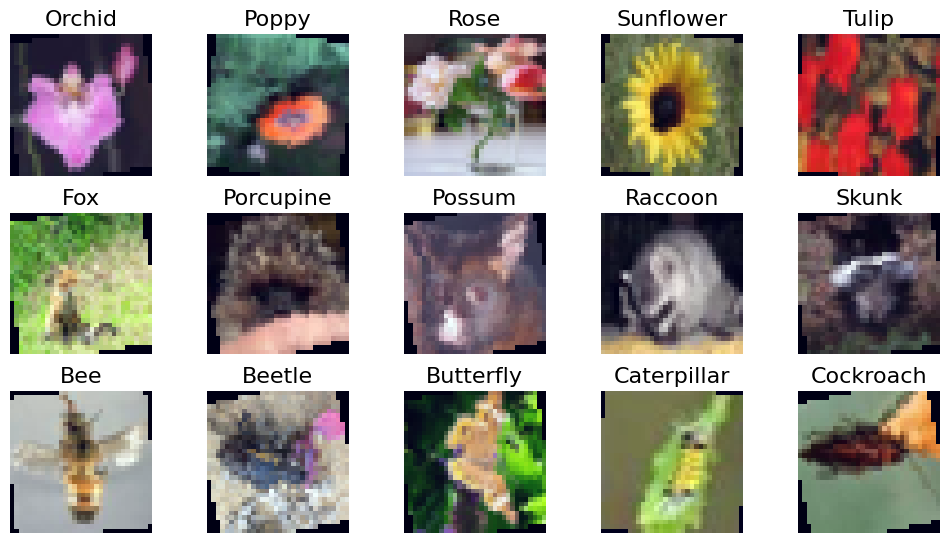

In [14]:
# Visualize a grid of random training images
helper_utils.visualise_images(train_loader, grid=(3, 5))

<a name='2'></a>
## 2 - Construyendo una CNN Modular y Robusta

Con un data pipeline más robusto en su lugar, tu siguiente paso es mejorar la arquitectura del modelo en sí. Refactorizarás la CNN original para que sea más modular, eficiente y potente. Este es el siguiente paso fundamental para resolver el problema del overfitting y llevar el rendimiento de tu modelo a nuevas alturas.

<a name='2-1'></a>
### 2.1 - El Poder de la Modularidad: El CNNBlock

En el laboratorio anterior, la arquitectura de tu modelo tenía un patrón repetitivo de capas de convolución, activación y pooling. Definir estas capas individualmente puede volverse repetitivo y hace que el modelo sea más difícil de modificar. Un enfoque mucho mejor es agrupar estos patrones en un solo módulo reutilizable. Tu primera tarea es crear un `CNNBlock` que empaquete estas capas juntas. Este diseño modular hace que el código de tu modelo principal sea significativamente más limpio y fácil de manejar.

<a name='2-1-1'></a>
#### 2.1.1 - <code>[Capa BatchNorm2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)</code>

Como parte de este nuevo bloque mejorado, también introducirás una nueva y potente capa: `BatchNorm2d`. Esta capa es una técnica fundamental para construir redes neuronales profundas modernas de alto rendimiento.

Piensa en el Batch Normalization como un controlador de tráfico para los datos que fluyen entre las capas de tu red. Después de que una capa convolucional procesa un lote de imágenes, las salidas (o activaciones) pueden tener distribuciones que varían ampliamente de un lote al siguiente. `BatchNorm2d` interviene y normaliza estas activaciones dentro de cada mini-batch, ajustándolas para que tengan una media y una desviación estándar consistentes. Luego utiliza dos parámetros aprendibles para escalar y desplazar esta salida normalizada, permitiendo que la red misma aprenda la distribución óptima para los datos en ese punto.



Este paso, aparentemente simple, proporciona tres beneficios profundos:

* **Estabiliza y Acelera el Entrenamiento**: Al mantener la distribución de los datos consistente entre capas, evita que las capas posteriores tengan que adaptarse constantemente a una entrada cambiante de las capas anteriores. Esta estabilidad te permite usar tasas de aprendizaje (learning rates) más altas, lo que puede acelerar drásticamente la rapidez con la que aprende tu modelo.

* **Actúa como un Regularizador**: Debido a que las estadísticas de normalización se calculan para cada mini-batch único, introduce una pequeña cantidad de ruido en el proceso de entrenamiento. Este ruido hace que sea más difícil para el modelo memorizar perfectamente los datos de entrenamiento, alentándolo a aprender características más generales y, por lo tanto, reduciendo el overfitting.

* **Reduce la Sensibilidad a la Inicialización**: La capa hace que tu modelo dependa menos de los pesos aleatorios específicos con los que comienza, lo que lleva a resultados de entrenamiento más confiables y repetibles.

Al añadir `BatchNorm2d` a tu `CNNBlock`, no solo estás añadiendo otra capa; estás haciendo fundamentalmente que el proceso de entrenamiento de tu modelo sea más estable, eficiente y robusto.

<a name='ex-2'></a>
### Exercise 2 - CNNBlock

Ahora implementarás la clase `CNNBlock`. Esta clase empaquetará las cuatro capas en un único módulo `nn.Sequential`.

**Tu Tarea**:

**Dentro del método `__init__`**:
> * Necesitas definir un contenedor secuencial llamado `self.block`.
> * Dentro de este contenedor <code>[nn.Sequential](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html)</code>, añadirás las siguientes capas en orden:
>    1. Una capa <code>[nn.Conv2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)</code>. Usa los argumentos `in_channels`, `out_channels`, `kernel_size`, y `padding` que se pasan al método `__init__`.
>    2. Una capa <code>[nn.BatchNorm2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)</code>. Esta capa necesita conocer el número de canales de su entrada, que es la salida de la capa convolucional anterior.
>    3. Una función de activación <code>[nn.ReLU](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)</code>.
>    4. Una capa <code>[nn.MaxPool2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)</code>. Esto reducirá la resolución del mapa de características. Debes configurar tanto el `kernel_size` como el `stride` en `2`.

**Dentro del método `forward`**:

> * Este método realiza el paso hacia adelante (forward pass).
> * Pasa el tensor de entrada `x` a través del `self.block` que definiste y devuelve el resultado.

<details>
<summary><b><font color="green">Additional Code Hints (Haz clic para expandir si estás atascado)</font></b></summary>

Si buscas más orientación, aquí tienes un desglose detallado.

**Para el método `__init__`**:

* Estás definiendo una secuencia de capas. Toda la secuencia se asignará a `self.block`. La estructura comienza así: `self.block = nn.Sequential(...)`.

* Las capas se proporcionan como argumentos a `nn.Sequential`, separadas por comas.

* **1. Capa Convolucional**: La primera capa es `nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)`. Nota cómo utiliza los parámetros de la firma del método `__init__`.

* **2. Capa Batch Norm**: La segunda capa es `nn.BatchNorm2d(...)`. Necesita un argumento: el número de canales que normalizará. Esto es igual al número de canales de salida de la capa anterior, que es `out_channels`.

* **3. Capa ReLU**: La tercera capa es simplemente `nn.ReLU()`. No requiere ningún argumento.

* **4. Capa Max Pooling**: La capa final es `nn.MaxPool2d(...)`. Necesitas proporcionar el `kernel_size` y el `stride`. La llamada se verá así: `nn.MaxPool2d(kernel_size=2, stride=2)`.

**Para el método `forward`**:

* Esta es una sola línea de código. Simplemente necesitas llamar al módulo que creaste en el método `__init__` sobre el tensor de entrada.
* El pseudocódigo sería: `devolver el resultado de aplicar self.block a la entrada x`.

</details>

In [15]:
# GRADED CLASS: CNNBlock

class CNNBlock(nn.Module):
    """
    Define un bloque convolucional simple para una CNN.

    Este bloque consiste en una capa convolucional, batch normalization,
    una activación ReLU y una capa de max-pooling, agrupados como un módulo secuencial.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        """
        Inicializa las capas del CNNBlock.

        Args:
            in_channels (int): Número de canales en la imagen de entrada.
            out_channels (int): Número de canales producidos por la convolución.
            kernel_size (int, opcional): Tamaño del kernel de convolución. Por defecto es 3.
            padding (int, opcional): Zero-padding añadido a ambos lados de la entrada. Por defecto es 1.
        """
        # Inicializa la clase padre nn.Module.
        super(CNNBlock, self).__init__()
        
        ### START CODE HERE ###
        
        # Define el contenedor secuencial para las capas del bloque.
        self.block = nn.Sequential(
            # Capa convolucional 2D para aplicar filtros aprendibles a la entrada.
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
            # Batch normalization para estabilizar y acelerar el entrenamiento.
            nn.BatchNorm2d(out_channels),
            # Función de activación ReLU para introducir no-linealidad.
            nn.ReLU(),
            # Capa de max pooling para reducir la resolución del feature map y las dimensiones espaciales.
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        ) 
        
        ### END CODE HERE ###

    def forward(self, x):
        """
        Define el forward pass para el CNNBlock.

        Args:
            x: El tensor de entrada para el bloque.

        Returns:
            El tensor de salida después de pasar por el bloque.
        """
        
        ### START CODE HERE ###
        
        # Pasa el tensor de entrada a través del bloque secuencial de capas.
        return self.block(x)
    
        ### END CODE HERE ###

In [16]:
# Verify the CNNBlock
print("--- Verifying CNNBlock ---\n")

# Instancia el bloque con 3 canales de entrada y 16 canales de salida
verify_cnn_block = CNNBlock(in_channels=3, out_channels=16)
print("Estructura del Bloque:\n")
print(verify_cnn_block)

# Verifica la forma de la salida (output shape) después de un forward pass
# Crea un tensor de entrada ficticio (batch_size=1, channels=3, height=32, width=32)
dummy_input = torch.randn(1, 3, 32, 32)
print(f"\nForma del tensor de entrada:  {dummy_input.shape}")

# Pasa el tensor ficticio a través del bloque
output = verify_cnn_block(dummy_input)
print(f"Forma del tensor de salida: {output.shape}")

--- Verifying CNNBlock ---

Estructura del Bloque:

CNNBlock(
  (block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

Forma del tensor de entrada:  torch.Size([1, 3, 32, 32])
Forma del tensor de salida: torch.Size([1, 16, 16, 16])


#### Expected Output:

```
Block Structure:

CNNBlock(
  (block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

Input tensor shape:  torch.Size([1, 3, 32, 32])
Output tensor shape: torch.Size([1, 16, 16, 16])
```

In [ ]:
# Test your code!
unittests.exercise_2(CNNBlock)

<a name='2-2'></a>
### 2.2 - Assembling the Full CNN with Modular Blocks

Ahora que tienes un `CNNBlock` reutilizable, puedes ensamblar tu arquitectura `SimpleCNN` completa. Al usar tu nuevo bloque modular, verás cuánto más limpia y profesional se vuelve la definición de tu modelo. En lugar de definir muchas capas individuales para la parte convolucional de tu red, ahora definirás solo tres instancias de `CNNBlock`.

Tu modelo constará de dos partes principales:

* **Un extractor de características (Feature extractor)**: Una secuencia de tres CNNBlocks que aprenderán a identificar patrones visuales en las imágenes.
* **Un clasificador (Classifier)**: Una secuencia de capas completamente conectadas (fully connected) que tomarán las características de los bloques convolucionales y realizarán la predicción final.

En esta nueva versión, también aumentarás la **tasa de dropout a `0.6`**. Este es otro paso importante en tu lucha contra el overfitting, ya que hace que el modelo sea menos propenso a depender de una sola característica.



<a name='ex-3'></a>
### Exercise 3 - SimpleCNN

Ahora implementarás los métodos `__init__` y `forward` para la clase `SimpleCNN`. Utilizarás el `CNNBlock` que acabas de construir como el componente principal del cuerpo de la red.

**Tu Tarea**:

**Dentro del método `__init__`**:

> * **Feature Extractor**:
>
>    * Instancia tres capas `CNNBlock` (`conv_block1`, `conv_block2`, `conv_block3`).
>    * El primer bloque debe recibir una entrada de **3 canales** (para imágenes RGB) y producir **32 canales de salida**.
>    * Para los bloques subsiguientes, el número de canales de entrada debe coincidir con el número de canales de salida del bloque anterior. Duplicarás el número de canales en cada paso `(3 -> 32 -> 64 -> 128)`.

> * **Classifier**:
>
>    * Define un `self.classifier` usando un contenedor `nn.Sequential`.
>    * Este contenedor debe tener las siguientes capas en orden:
>        1. Una capa <code>[nn.Flatten](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)</code> para transformar el mapa de características 2D en un vector 1D.
>        2. Una capa <code>[nn.Linear](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)</code>. Debes calcular el número correcto de características de entrada. Esto depende de la forma de salida del último `CNNBlock`. El tamaño de salida de esta capa debe ser **512**.
>        3. Una activación `nn.ReLU`.
>        4. Una capa <code>[nn.Dropout](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)</code> con una tasa de `0.6` para ayudar a prevenir el overfitting.
>        5. Una capa `nn.Linear` final que mapee las **512 características** al **número de clases de salida**.

**Dentro del método `forward`**:
>
>    * Define el flujo de datos a través de la red.
>    * Pasa la entrada `x` secuencialmente a través de `conv_block1`, luego `conv_block2` y finalmente `conv_block3`.
>    * Finalmente, pasa la salida del último bloque convolucional a través de tu `classifier`.
>    * Devuelve la salida final.

<details>
<summary><b><font color="green">Additional Code Hints (Haz clic para expandir si estás atascado)</font></b></summary>

Si estás atascado, aquí tienes un desglose más detallado para la implementación.

**Para el método `__init__`**:

* **Bloques Convolucionales**:
>    
    * El primer bloque es una instanciación directa: `self.conv_block1 = CNNBlock(in_channels=3, out_channels=32)`.
    * Para el segundo bloque, los `in_channels` deben ser `32` (los `out_channels` del primero). Los `out_channels` serán `64`. Sigue este patrón para el tercer bloque.
>
* **Clasificador**:

    * Comienza definiendo el contenedor secuencial: `self.classifier = nn.Sequential(...)`
    **1. Capa Flatten**: La primera capa es `nn.Flatten()`. No recibe argumentos.
    **2. Primera Capa Lineal**: Es `nn.Linear(in_features=..., out_features=512)`.
        * Para encontrar los `in_features`, necesitas calcular el tamaño del tensor aplanado. Las imágenes de entrada son de 32x32. Cada `CNNBlock` contiene una capa `MaxPool2d` con un stride de 2, lo que reduce a la mitad la altura y el ancho. Después de tres bloques, las dimensiones serán `32 → 16 → 8 → 4`.
        * El último `CNNBlock` produce 128 canales. Por lo tanto, el número total de características es `128 * 4 * 4`.
    **3. Capa ReLU**: Añade `nn.ReLU()`.
    **4. Capa Dropout**: Añade `nn.Dropout(0.6)`.
    **5. Capa Lineal Final**: Es `nn.Linear(in_features=512, out_features=num_classes)`.



**Para el método `forward`**:
>
* Este método describe cómo fluyen los datos de la entrada a la salida. Puedes usar la misma variable `x` y reasignarla después de cada paso.
* El pseudocódigo para la secuencia es:
    * `x = pasar la entrada x a través de self.conv_block1`
    * `x = pasar la nueva x a través de self.conv_block2`
    * `x = pasar la nueva x a través de self.conv_block3`
    * `x = pasar el mapa de características final a través de self.classifier`
* Finalmente, devuelve `x`.

</details>

In [19]:
# GRADED CLASS: SimpleCNN

class SimpleCNN(nn.Module):
    """
    Define una arquitectura CNN simple utilizando bloques modulares CNNBlocks.

    Este modelo apila tres bloques convolucionales reutilizables seguidos de un
    clasificador completamente conectado (fully connected) para realizar la clasificación de imágenes.
    """
    def __init__(self, num_classes):
        """
        Inicializa las capas del modelo SimpleCNN.

        Args:
            num_classes (int): El número de clases de salida para el clasificador.
        """
        # Inicializa la clase padre nn.Module.
        super(SimpleCNN, self).__init__()
        
        ### START CODE HERE ###

        # Define el primer bloque convolucional.
        self.conv_block1 = CNNBlock(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        # Define el segundo bloque convolucional.
        self.conv_block2 = CNNBlock(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Define el tercer bloque convolucional.
        self.conv_block3 = CNNBlock(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Define el bloque clasificador completamente conectado.
        self.classifier = nn.Sequential(
            # Aplana (Flatten) el feature map 3D (canales, alto, ancho) en un vector 1D.
            nn.Flatten(),
            # Primera capa totalmente conectada (linear) que mapea las características aplanadas a una capa oculta.
            nn.Linear(in_features=128 * 4 * 4, out_features=512),
            # Función de activación ReLU para introducir no-linealidad.
            nn.ReLU(),
            # Capa Dropout para prevenir el overfitting estableciendo aleatoriamente una fracción de entradas a cero.
            nn.Dropout(p=0.5),
            # Capa totalmente conectada (linear) final que mapea la capa oculta a las clases de salida.
            nn.Linear(in_features=512, out_features=num_classes)
        ) 
        
        ### END CODE HERE ###

    def forward(self, x):
        """
        Define el forward pass del modelo SimpleCNN.

        Args:
            x (torch.Tensor): El tensor de entrada que contiene un batch de imágenes.

        Returns:
            torch.Tensor: El tensor de salida con los logits para cada clase.
        """
        
        ### START CODE HERE ###
        
        # Pasa la entrada a través del primer bloque convolucional.
        x = self.conv_block1(x)
        # Pasa el resultado a través del segundo bloque convolucional.
        x = self.conv_block2(x)
        # Pasa el resultado a través del tercer bloque convolucional.
        x = self.conv_block3(x)

        # Pasa el feature map final a través del clasificador.
        x = self.classifier(x)
        
        ### END CODE HERE ###
        
        # Retorna el tensor de salida final.
        return x

In [20]:
# Verify the SimpleCNN
print("--- Verificando SimpleCNN ---\n")

# Verifica la estructura del modelo
# Instancia el modelo con 15 clases de salida
verify_simple_cnn = SimpleCNN(num_classes=15)
print("Estructura del Modelo:\n")
print(verify_simple_cnn)

# Verifica la forma de la salida (output shape) después de un forward pass
# Crea un tensor de entrada ficticio (batch_size=64, channels=3, height=32, width=32)
dummy_input = torch.randn(64, 3, 32, 32)
print(f"\nForma del tensor de entrada:  {dummy_input.shape}")

# Pasa el tensor ficticio a través del modelo
output = verify_simple_cnn(dummy_input)
print(f"Forma del tensor de salida: {output.shape}")

--- Verificando SimpleCNN ---

Estructura del Modelo:

SimpleCNN(
  (conv_block1): CNNBlock(
    (block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block2): CNNBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block3): CNNBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel

#### Expected Output:

```
Model Structure:

SimpleCNN(
  (conv_block1): CNNBlock(
    (block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block2): CNNBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block3): CNNBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=512, out_features=15, bias=True)
  )
)

Input tensor shape:  torch.Size([64, 3, 32, 32])
Output tensor shape: torch.Size([64, 15])
```

<br>

**NOTA**: La prueba a continuación evalúa tu clase `SimpleCNN`, la cual utiliza internamente el `CNNBlock` que implementaste en el ejercicio anterior. Si no pasaste la prueba del `Ejercicio 2 - CNNBlock`, ejecutar la siguiente celda probablemente devolverá un error. ¡Por favor, asegúrate de que tu implementación de `CNNBlock` sea correcta primero!

In [ ]:
# Test your code!
unittests.exercise_3(SimpleCNN, CNNBlock)

<br>

Con tu clase `SimpleCNN` definida, el siguiente paso es crear una instancia del modelo.

* Primero, determina dinámicamente el número de clases obteniendo la longitud (length) del atributo `.classes` de tu `train_dataset`.
* Luego, crea una instancia de tu modelo `SimpleCNN`, pasando la variable `num_classes` a su constructor. Esto asegura que la capa final de tu modelo tenga el tamaño correcto para tu problema de 15 clases.

In [21]:
# Get the number of classes
num_classes = len(train_dataset.classes)

# Instantiate the model
model = SimpleCNN(num_classes)

<a name='3'></a>
## 3 - Entrenando el Modelo Mejorado

Con tu data pipeline actualizado y tu arquitectura CNN modular completa, estás listo para comenzar el proceso de entrenamiento. En esta sección, configurarás las piezas finales de tu pipeline de entrenamiento: la función de pérdida (loss function) y el optimizador. Luego, implementarás la lógica central de entrenamiento y validación que ejecutará tu experimento y revelará qué tan bien funciona tu nuevo modelo.

<a name='3-1'></a>
### 3.1 - Configurando la Pérdida y el Optimizador

Antes de poder entrenar el modelo, debes definir dos componentes clave: una función de pérdida para medir el error y un optimizador para actualizar los pesos del modelo.

* Para la función de pérdida, seguirás utilizando `nn.CrossEntropyLoss`, la elección estándar para la clasificación multiclase.
>
* Para el optimizador, usarás `Adam`, pero con una adición importante para combatir el overfitting: el `weight_decay` (decaimiento de pesos). 
    * El weight decay añade una penalización a la función de pérdida basada en la magnitud de los pesos del modelo. Esto motiva a la red a aprender valores de peso más pequeños y simples, lo que la hace más robusta y menos propensa a memorizar los datos de entrenamiento. Esta es otra herramienta vital para mejorar la capacidad de generalización de tu modelo.

In [24]:
# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer for the model with weight_decay
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)

<a name='3-2'></a>
### 3.2 - Implementando la Lógica de Entrenamiento y Validación

Ahora implementarás la lógica central para entrenar y evaluar tu modelo. Esto se hará en dos funciones separadas:

* `train_epoch`: Para realizar una sola pasada sobre los datos de entrenamiento para actualizar el modelo.
* `validate_epoch`: Para realizar una sola pasada sobre los datos de validación para medir el rendimiento.



<a name='ex-4'></a>
### Exercise 4 - train_epoch

Tu tarea es completar la lógica central de entrenamiento dentro del bucle `for` de la función `train_epoch`. Implementarás los cinco pasos fundamentales de una sola iteración de entrenamiento.

**Tu Tarea**:

Dentro de la función `train_epoch`, para cada batch de `images` y `labels`:

* **Limpiar Gradientes**: 
    * Antes de calcular los gradientes para el batch actual, debes limpiar cualquier gradiente que haya quedado almacenado del batch anterior.
* **Paso hacia adelante (Forward Pass)**: 
    * Alimenta el `model` con las `images` para obtener las predicciones de salida.
* **Calcular la Pérdida**: 
    * Usa la `loss_function` proporcionada para medir la diferencia entre las `outputs` del modelo y las `labels` reales.
* **Paso hacia atrás (Backward Pass)**: 
    * Calcula los gradientes de la pérdida con respecto a todos los parámetros del modelo. Esto también se conoce como retropropagación (backpropagation).
* **Actualizar Parámetros**: 
    * Usa el `optimizer` para ajustar los parámetros del modelo basándote en los gradientes que acabas de calcular.

<details>
<summary><b><font color="green">Additional Code Hints (Haz clic para expandir si estás atascado)</font></b></summary>

Si necesitas ayuda, aquí tienes una guía más directa para cada paso.

* **Limpiar Gradientes**: Esto se hace para evitar la acumulación de gradientes entre batches.
    * El pseudocódigo es: `llamar al método zero_grad() en el optimizer`.
>
* **Forward Pass**: Así es como obtienes las predicciones del modelo para el batch actual.
    * El pseudocódigo es: `outputs = llamar al model, pasando las images como argumento`.
>
* **Calcular la Pérdida**: Comparas las predicciones del modelo con las etiquetas reales (ground truth).
    * El pseudocódigo es: `loss = llamar a la loss_function, pasando las outputs y labels como argumentos`.
>
* **Backward Pass**: Este paso calcula cuánto contribuyó cada parámetro del modelo a la pérdida global.
    * El pseudocódigo es: `llamar al método backward() en el tensor de la pérdida (loss)`.
>     
* **Update Parameters**: El optimizador utiliza los gradientes calculados para dar un pequeño paso en la dirección que minimiza la pérdida.
    * El pseudocódigo es: `llamar al método step() en el optimizer`.

</details>

In [25]:
# GRADED FUNCTION: train_epoch

def train_epoch(model, train_loader, loss_function, optimizer, device):
    """
    Realiza una única época de entrenamiento.

    Args:
        model (torch.nn.Module): El modelo de red neuronal a entrenar.
        train_loader (torch.utils.data.DataLoader): El DataLoader para los datos de entrenamiento.
        loss_function (callable): La función de pérdida.
        optimizer (torch.optim.Optimizer): El optimizador.
        device (torch.device): El dispositivo (CPU o GPU) donde se realizará el entrenamiento.

    Returns:
        float: La pérdida (loss) promedio de entrenamiento para la época.
    """
    # Establece el modelo en modo de entrenamiento
    model.train()
    running_loss = 0.0
    # Itera sobre los lotes (batches) de datos en el training loader
    for images, labels in train_loader:
        # Mueve las imágenes y etiquetas al dispositivo especificado (GPU o CPU)
        images, labels = images.to(device), labels.to(device)
        
        ### START CODE HERE ###
        
        # Limpia los gradientes de todas las variables optimizadas
        optimizer.zero_grad()
        # Realiza un forward pass para obtener las salidas del modelo
        outputs = model(images)
        # Calcula la pérdida (loss)
        loss = loss_function(outputs, labels)
        # Realiza un backward pass para calcular los gradientes
        loss.backward()
        # Actualiza los parámetros del modelo
        optimizer.step()
        
        ### END CODE HERE ###
        
        # Acumula la pérdida de entrenamiento para el lote actual
        running_loss += loss.item() * images.size(0)
        
    # Calcula y retorna la pérdida promedio de entrenamiento para la época
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [26]:
# Usa una función auxiliar para realizar una prueba de integridad (sanity check) en la implementación de train_epoch
helper_utils.verify_training_process(SimpleCNN, train_loader, loss_function, train_epoch, device)

--- Verifying train_epoch (training for 5 epochs) ---

Training on 640 images for 5 epochs:

Epoch [1/5], Loss: 2.6281
Epoch [2/5], Loss: 2.1933
Epoch [3/5], Loss: 1.9442
Epoch [4/5], Loss: 1.7537
Epoch [5/5], Loss: 1.6118

Weight Update Check:	Model weights changed during training.
Loss Trend Check:	Loss decreased from 2.6281 to 1.6118.


#### Expected Output (Approximately):

```
Training on 640 images for 5 epochs:

Epoch [1/5], Loss: 2.6735
Epoch [2/5], Loss: 2.3238
Epoch [3/5], Loss: 2.0528
Epoch [4/5], Loss: 1.8341
Epoch [5/5], Loss: 1.7676

Weight Update Check:	Model weights changed during training.
Loss Trend Check:	Loss decreased from 2.6735 to 1.7676.
```

In [ ]:
# Test your code!
unittests.exercise_4(train_epoch)

<a name='ex-5'></a>
### Exercise 5 - validate_epoch

Tu tarea es completar la lógica de validación. Esto implica realizar un forward pass y luego calcular tanto la pérdida (loss) como el número de predicciones correctas para determinar el accuracy.



**Tu Tarea**:

* **Desactivar el Cálculo de Gradientes**:
>
    * Envuelve todo el bucle for dentro del context manager `torch.no_grad()`. Esto le indica a PyTorch que no calcule gradientes, lo que ahorra memoria y tiempo de cómputo durante la validación.
>
* **Dentro del bucle `for`**:
>
    * **Paso hacia adelante (Forward Pass)**: 
        * Al igual que en el entrenamiento, pasa las `images` a través del `model` para obtener sus `outputs`.        
    * **Calcular la Pérdida**: 
        * Usa la `loss_function` para calcular la `val_loss` entre las `outputs` y las `labels` reales.
    * **Acumular la Pérdida**: 
        * Añade la pérdida del lote a `running_val_loss`. Recuerda obtener el valor escalar del tensor de pérdida y escalarlo por el tamaño del lote (batch size).
    * **Obtener Predicciones**: 
        * Determina la clase predicha por el modelo para cada imagen del lote. Las `outputs` de tu modelo son puntuaciones brutas (logits). La clase con la puntuación más alta es la predicción del modelo. Debes encontrar el índice de esta puntuación máxima.

<details>
<summary><b><font color="green">Additional Code Hints (Haz clic para expandir si estás atascado)</font></b></summary>

Si necesitas un poco más de orientación, aquí tienes una guía detallada.

**Desactivar el Cálculo de Gradientes**:
>
Este es un context manager en PyTorch. La estructura que necesitas es `with torch.no_grad():`. El bucle for debe estar indentado dentro de este bloque.

**Dentro del bucle for**:
   
* **Forward Pass**: Es idéntico al bucle de entrenamiento. El pseudocódigo es: `outputs = llamar al model, pasando las images como argumento`.

* **Calcular la Pérdida**: También es igual que en el bucle de entrenamiento. El pseudocódigo es: `val_loss = llamar a la loss_function, pasando las outputs y labels como argumentos`.

* **Acumular la Pérdida**: Necesitas actualizar `running_val_loss`. El pseudocódigo es: `running_val_loss += obtener el valor escalar de val_loss usando el método .item() * el número de imágenes en el lote actual`.

* **Obtener Predicciones**: Necesitas encontrar la clase más probable a partir de los logits de salida.

    * La función `torch.max()` es perfecta para esto. Debes llamarla sobre el tensor `outputs` a lo largo de la dimensión 1 (la dimensión de las clases).

    * El pseudocódigo es: `_, predicted = usar torch.max() en el tensor outputs, especificando la dimensión 1`.

    * Ten en cuenta que `torch.max()` devuelve una tupla de (valores_máximos, índices_máximos). Solo necesitas el segundo elemento, los índices, que corresponden a las etiquetas de clase predichas.

</details>

In [27]:
# GRADED FUNCTION: validate_epoch

def validate_epoch(model, val_loader, loss_function, device):
    """
    Realiza una única época de validación.

    Args:
        model (torch.nn.Module): El modelo de red neuronal a validar.
        val_loader (torch.utils.data.DataLoader): El DataLoader para los datos de validación.
        loss_function (callable): La función de pérdida.
        device (torch.device): El dispositivo (CPU o GPU) donde se realizará la validación.

    Returns:
        tuple: Una tupla que contiene la pérdida de validación promedio y el accuracy de validación.
    """
    # Establece el modelo en modo de evaluación
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    
    ### START CODE HERE ###
    
    # Desactiva el cálculo de gradientes para la validación
    with torch.no_grad():
        
    ### END CODE HERE ###
    
        # Itera sobre los lotes (batches) de datos en el validation loader
        for images, labels in val_loader:
            # Mueve las imágenes y etiquetas al dispositivo especificado
            images, labels = images.to(device), labels.to(device)
            
            ### START CODE HERE ###
            
            # Realiza un forward pass para obtener las salidas del modelo
            outputs = model(images)
            
            # Calcula la pérdida de validación para el lote
            val_loss = loss_function(outputs, labels)
            # Acumula la pérdida de validación
            running_val_loss += val_loss.item()
            
            # Obtiene las etiquetas de clase predichas
            _, predicted = torch.max(outputs.data, 1)
            
            ### END CODE HERE ###
            
            # Actualiza el número total de muestras
            total += labels.size(0)
            # Actualiza el número de predicciones correctas
            correct += (predicted == labels).sum().item()
            
    # Calcula la pérdida de validación promedio y el accuracy para la época
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_accuracy = 100.0 * correct / total
    
    return epoch_val_loss, epoch_accuracy

In [28]:
# Usa una función auxiliar para realizar una prueba de integridad (sanity check) en la implementación de validate_epoch
helper_utils.verify_validation_process(SimpleCNN, val_loader, loss_function, validate_epoch, device)

--- Verifying validate_epoch ---

Validating on 640 images:

Returned Validation Loss: 0.0423
Returned Validation Accuracy: 8.75%


Return Types Check:	Function returned a float for loss and accuracy.
Weight Integrity Check:	Model weights were not changed during validation.


#### Expected Output:

```
Return Types Check:	Function returned a float for loss and accuracy.
Weight Integrity Check:	Model weights were not changed during validation.
```

In [ ]:
# Test your code!
unittests.exercise_5(validate_epoch)

---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. Feel free to [submit](#submission) your work now. The grading process runs in the background, so it will not disrupt your progress and you can continue on with the rest of the material.

**🚨 IMPORTANT NOTE** If you have passed all tests within the notebook, but the autograder shows a system error after you submit your work:

<div style="background-color: #1C1C1E; border: 1px solid #444444; color: #FFFFFF; padding: 15px; border-radius: 5px;">
    <p><strong>Grader Error: Grader feedback not found</strong></p>
    <p>Autograder failed to produce the feedback...</p>
</div>
<br>

This is typically a temporary system glitch. The most common solution is to resubmit your assignment, as this often resolves the problem. Occasionally, it may be necessary to resubmit more than once. 
>
If the error persists, please reach out for support in the [DeepLearning.AI Community Forum](https://community.deeplearning.ai/c/course-q-a/pytorch-for-developers/pytorch-fundamentals/560).

---

Con las funciones individuales de entrenamiento y validación completadas, ahora puedes integrarlas en el `training_loop` principal. Esta función orquestará todo el proceso de entrenamiento durante un número determinado de épocas e incluye una mejora fundamental.

Un desafío común es que el rendimiento de un modelo puede alcanzar un máximo y luego declinar si el entrenamiento continúa por demasiado tiempo. Para solucionar esto, el `training_loop`:

* **Monitorea** el accuracy de validación al final de cada época.
* **Hace un seguimiento** del estado del modelo con mejor rendimiento visto hasta el momento.
* Después de la época final, automáticamente **devuelve el modelo de su mejor época individual**.

Esto garantiza que siempre recuperes la versión de tu modelo que logró el mayor accuracy de validación durante todo el proceso de entrenamiento.

In [29]:
def training_loop(model, train_loader, val_loader, loss_function, optimizer, num_epochs, device):
    """
    Entrena y valida un modelo de red neuronal en PyTorch.

    Args:
        model (torch.nn.Module): El modelo a ser entrenado.
        train_loader (torch.utils.data.DataLoader): DataLoader para el conjunto de entrenamiento.
        val_loader (torch.utils.data.DataLoader): DataLoader para el conjunto de validación.
        loss_function (callable): La función de pérdida (loss function).
        optimizer (torch.optim.Optimizer): El algoritmo de optimización.
        num_epochs (int): El número total de épocas (epochs) para entrenar.
        device (torch.device): El dispositivo (ej. 'cuda' o 'cpu') donde se ejecutará el entrenamiento.

    Returns:
        tuple: Una tupla que contiene el mejor modelo entrenado y una lista de métricas
               (train_losses, val_losses, val_accuracies).
    """
    # Mover el modelo al dispositivo especificado (CPU o GPU)
    model.to(device)
    
    # Inicializar variables para rastrear el modelo con mejor rendimiento
    best_val_accuracy = 0.0
    best_model_state = None
    best_epoch = 0
    
    # Inicializar listas para almacenar las métricas de entrenamiento y validación
    train_losses, val_losses, val_accuracies = [], [], []
    
    print("--- Entrenamiento Iniciado ---")
    
    # Bucle sobre el número especificado de épocas
    for epoch in range(num_epochs):
        # Realizar una época de entrenamiento
        epoch_loss = train_epoch(model, train_loader, loss_function, optimizer, device)
        train_losses.append(epoch_loss)
        
        # Realizar una época de validación
        epoch_val_loss, epoch_accuracy = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_accuracy)
        
        # Imprimir las métricas para la época actual
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_accuracy:.2f}%")
        
        # Verificar si el modelo actual es el mejor hasta ahora
        if epoch_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_accuracy
            best_epoch = epoch + 1
            # Guardar el estado del mejor modelo en memoria (deep copy)
            best_model_state = copy.deepcopy(model.state_dict())
            
    print("--- Entrenamiento Finalizado ---")
    
    # Cargar los pesos del mejor modelo antes de retornar
    if best_model_state:
        print(f"\n--- Retornando el mejor modelo con {best_val_accuracy:.2f}% de validation accuracy, logrado en la época {best_epoch} ---")
        model.load_state_dict(best_model_state)
    
    # Consolidar todas las métricas en una sola lista
    metrics = [train_losses, val_losses, val_accuracies]
    
    # Retornar el modelo entrenado y las métricas recolectadas
    return model, metrics

Todo está ahora en su lugar. El siguiente código llamará a tu función `training_loop` para dar inicio al proceso completo de entrenamiento y validación.

El modelo se entrenará durante **50 epochs**. Con las potentes técnicas de regularización que has añadido (**Batch Normalization**, un **Dropout** incrementado y **Weight Decay**) y un **learning rate** más pequeño, el modelo está diseñado para aprender con mayor cautela. Este **training run** más prolongado le da al modelo el tiempo suficiente para converger hacia una solución robusta y generalizada.

--- Entrenamiento Iniciado ---
Epoch [1/50], Train Loss: 2.1181, Val Loss: 0.0279, Val Accuracy: 40.93%
Epoch [2/50], Train Loss: 1.7925, Val Loss: 0.0260, Val Accuracy: 44.27%
Epoch [3/50], Train Loss: 1.6574, Val Loss: 0.0235, Val Accuracy: 50.20%
Epoch [4/50], Train Loss: 1.5663, Val Loss: 0.0232, Val Accuracy: 50.07%
Epoch [5/50], Train Loss: 1.5139, Val Loss: 0.0219, Val Accuracy: 52.60%
Epoch [6/50], Train Loss: 1.4569, Val Loss: 0.0210, Val Accuracy: 54.13%
Epoch [7/50], Train Loss: 1.4179, Val Loss: 0.0227, Val Accuracy: 51.80%
Epoch [8/50], Train Loss: 1.3477, Val Loss: 0.0203, Val Accuracy: 57.33%
Epoch [9/50], Train Loss: 1.3149, Val Loss: 0.0191, Val Accuracy: 59.73%
Epoch [10/50], Train Loss: 1.2979, Val Loss: 0.0201, Val Accuracy: 57.67%
Epoch [11/50], Train Loss: 1.2776, Val Loss: 0.0187, Val Accuracy: 60.07%
Epoch [12/50], Train Loss: 1.2366, Val Loss: 0.0188, Val Accuracy: 60.20%
Epoch [13/50], Train Loss: 1.2016, Val Loss: 0.0180, Val Accuracy: 62.00%
Epoch [14/50], T

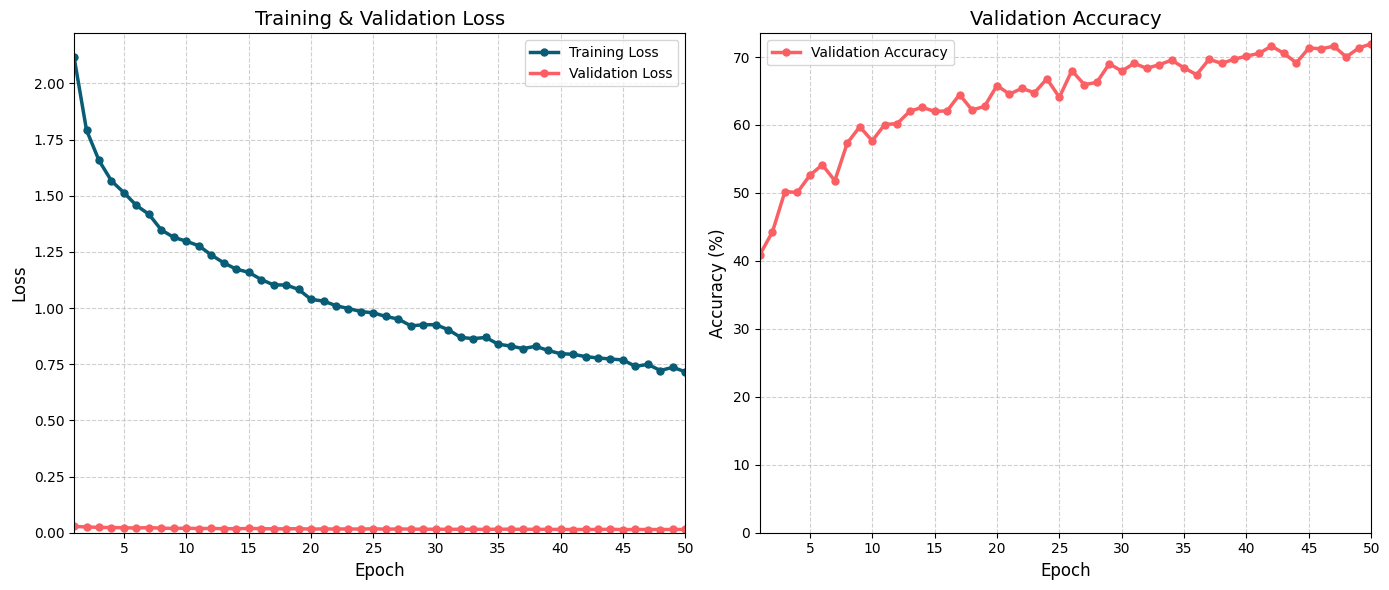

In [30]:
# Inicia el proceso de entrenamiento llamando a la función training_loop
trained_model, training_metrics = training_loop(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    loss_function=loss_function, 
    optimizer=optimizer, 
    num_epochs=50, 
    device=device
)

# Visualiza las métricas de entrenamiento (pérdida y accuracy)
print("\n--- Plots de Entrenamiento ---\n")
helper_utils.plot_training_metrics(training_metrics)

**Analizando los Resultados**

Observa de cerca los nuevos **plots** de entrenamiento y compáralos con los del laboratorio anterior. La diferencia es notable.

Las curvas de **training loss** y **validation loss** ahora se siguen muy de cerca, y la amplia brecha que señalaba el **overfitting** ha desaparecido. El **validation accuracy** muestra un ascenso mucho más saludable y consistente. ¡Esta es una evidencia clara de que has resuelto con éxito el problema del **overfitting**! La combinación de más **data augmentation**, **Batch Normalization** y **Weight Decay** trabajaron juntos para crear un modelo que generaliza mucho mejor que antes.



**La Meseta de Rendimiento (Performance Plateau)**

El **validation accuracy** de tu modelo ahora alcanza su punto máximo alrededor del 70%, lo cual es un resultado sólido. Sin embargo, podrías preguntarte por qué no alcanzó el 90% o más, especialmente con todas estas técnicas avanzadas y un entrenamiento más largo. La respuesta reside en qué tan efectivamente has utilizado las herramientas a tu disposición.

Los fundamentos que has aprendido en este curso proporcionan una base sólida para construir modelos de **deep learning**. Las técnicas que ahora tienes a tu disposición, desde el **data augmentation** hasta el diseño modular y la regularización, son potentes. Aplicarlas correctamente es precisamente lo que te permitió resolver el problema inicial de **overfitting** y lograr este resultado sólido. Esto demuestra que estás llevando al límite lo que se puede lograr con este **toolkit** fundamental.

Has logrado algo significativo. Empezaste construyendo una **CNN** simple que sufría de un problema común y desafiante, y mejoraste sistemáticamente todo tu **pipeline** con técnicas profesionales para crear este modelo final y robusto. ¡Felicitaciones por un resultado exitoso!

<a name='4'></a>
## 4 - Más allá de los Fundamentos: Un vistazo al siguiente nivel

Has logrado tomar una **CNN** simple, diagnosticar sus fallos y mejorarla sistemáticamente hasta convertirla en un modelo robusto y con buena generalización. Has llevado el **toolkit** fundamental que has aprendido hasta sus límites para lograr un resultado sólido.

**¿Pero qué tal si este no es el límite? ¿Qué tal si hubiera otro camino?**

**¿Qué tal si pudieras llevar el accuracy de tu modelo de un 70% a más del 80% en este mismo dataset?**

Echa un vistazo a los resultados de una estrategia de entrenamiento diferente y más potente. Ejecuta la siguiente celda para verlo en acción.

In [34]:
# Importa la función de vista previa que demuestra conceptos del próximo curso
from c2_preview.c2_preview import course_2_preview

# Esta función auxiliar ejecuta un bucle de entrenamiento utilizando una estrategia potente
# que se enseñará en el próximo curso. Ejecuta esta celda para ver los resultados mejorados en acción.
trained_model = course_2_preview(
    train_dataset, 
    val_dataset, 
    loss_function,
    device,
    num_epochs=5
)

Epoch 1/5 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [1/5], Train Loss: 1.5515, Val Loss: 0.8133, Val Accuracy: 73.67%


Epoch 2/5 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [2/5], Train Loss: 1.0527, Val Loss: 0.6639, Val Accuracy: 78.33%


Epoch 3/5 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [3/5], Train Loss: 0.9538, Val Loss: 0.6154, Val Accuracy: 79.60%


Epoch 4/5 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [4/5], Train Loss: 0.8867, Val Loss: 0.5733, Val Accuracy: 81.07%


Epoch 5/5 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [5/5], Train Loss: 0.8817, Val Loss: 0.5691, Val Accuracy: 81.07%

--- Returning best model with 81.07% validation accuracy, achieved at epoch 4 ---


<br>

Increíble, ¿verdad? En solo **5 epochs**, el **validation accuracy** superó el 80%, un nivel de rendimiento que tu modelo anterior no alcanzó ni después de 50 **epochs**.

**¿Cómo es posible una mejora tan rápida y dramática con exactamente los mismos datos?**

Este resultado se logró combinando varias técnicas potentes de siguiente nivel que dominarás en el próximo curso. Esto fue solo un **preview**, pero la estrategia involucró tres mejoras clave:

* **Uso de un Pre-trained Model**: Este es el cambio más significativo. En lugar de empezar de cero con pesos aleatorios, este enfoque utiliza un modelo sofisticado que ya ha sido entrenado en millones de imágenes. Ya posee una comprensión profunda de los patrones visuales, la cual puedes luego ajustar (**fine-tune**) para tu tarea específica.

* **Dynamic Learning Rate Scheduling**: En lugar de usar un único **learning rate** fijo, esta estrategia utiliza un *learning rate scheduler*. Esta herramienta ajusta inteligentemente el **learning rate** durante el entrenamiento, realizando actualizaciones más grandes al principio y ajustes más pequeños y precisos a medida que el modelo se acerca a la mejor solución.

* **Transformaciones más Avanzadas**: El pipeline de **data augmentation** utilizado para este **preview** también fue más avanzado. Incluyó técnicas diseñadas específicamente para estos modelos de alto rendimiento, asegurando que la red aprendiera de un conjunto de ejemplos de entrenamiento más rico y desafiante.

Estos conceptos son solo un vistazo de lo que viene después. Has construido una base increíble, y ahora estás listo para aprender las estrategias que los profesionales utilizan para lograr resultados **state-of-the-art** de manera rápida y eficiente.

## Conclusión

¡Felicitaciones por completar esta tarea!

Has navegado con éxito a través de un **workflow** de **machine learning** completo y realista. Comenzaste con un modelo que sufría de **overfitting**, diagnosticaste el problema y luego aplicaste sistemáticamente una serie de técnicas potentes y profesionales para resolverlo. No solo has mejorado un modelo; has aprendido un proceso repetible para refinar y fortalecer cualquier red neuronal que construyas en el futuro.

Las habilidades que practicaste aquí (diseño modular, implementación de regularización y análisis de la dinámica de entrenamiento) son fundamentales para construir modelos de **deep learning** efectivos. Has ido más allá de lo básico y ahora estás equipado con el conocimiento práctico necesario para abordar problemas más complejos del mundo real. ¡Bien hecho!